In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import wordnet
# Uncomment for first use
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
sns.set_style("whitegrid")

In [2]:
df=pd.read_csv('../data/train.csv')

**Taget : Identify wheter the tweet is about a real disaster or not**

# Basic Data Overview

In [3]:
df.head(50)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df['keyword'].nunique()

221

In [7]:
df['location'].nunique()

3341

**First observations**
* We have 5 columns and 7613 rows
* We have some missing values in location and keyword column
* We have 221 unique keywords and more than 3000 unique locations
* Locations are in different format in some rows

# EDA

**1. Target Analysis**

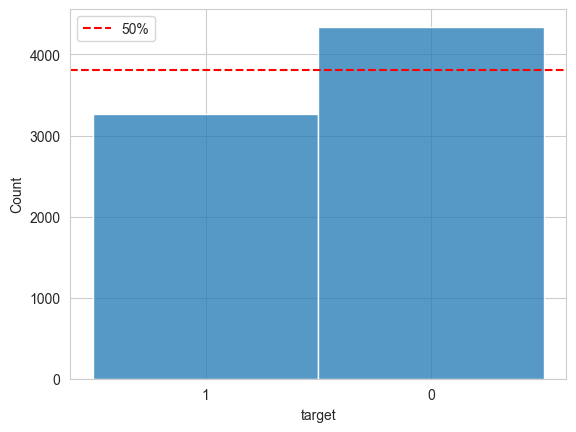

In [8]:
sns.histplot(df['target'].astype(str))
fifty_percent_count = len(df) / 2
plt.axhline(y=fifty_percent_count, color='red', linestyle='--', label='50%')
plt.legend()
plt.show()

In [9]:
target_percentage = df['target'].value_counts(normalize=True) * 100
percentage_table = pd.DataFrame({'Target': target_percentage.index, 'Percentage': target_percentage.values})
percentage_table

,Target,Percentage
0,0,57.034021
1,1,42.965979


There is a slight class imbalance - there are more false tweets

**Number of words in caps lock vs target**

In [10]:
def count_caps_lock(text):
    words = text.split()
    caps_lock_words = [word for word in words if word.isupper()]
    return len(caps_lock_words)


In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
df['Caps_lock_word_count'] = df['text'].apply(count_caps_lock)
df[['text','Caps_lock_word_count']].head(20)

,text,Caps_lock_word_count
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,0
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
3,"13,000 people receive #wildfires evacuation orders in California",0
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,0
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",0
7,I'm on top of the hill and I can see a fire in the woods...,1
8,There's an emergency evacuation happening now in the building across the street,0
9,I'm afraid that the tornado is coming to our area...,0


<Axes: xlabel='target', ylabel='Caps_lock_word_count'>

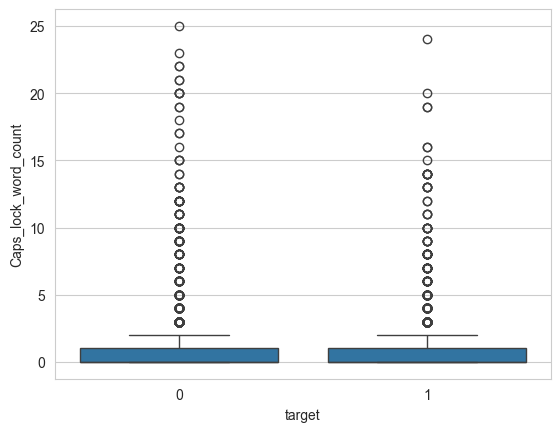

In [13]:
sns.boxplot(data=df, x='target', y='Caps_lock_word_count')

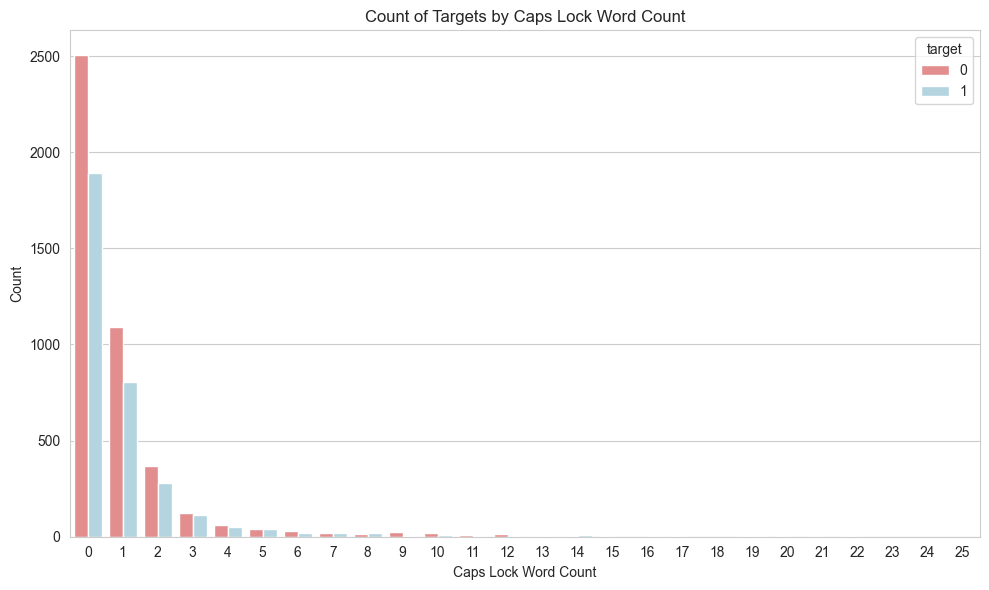

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Caps_lock_word_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.xlabel('Caps Lock Word Count')
plt.ylabel('Count')
plt.title('Count of Targets by Caps Lock Word Count')
plt.tight_layout()
plt.show()

We can see that the majority of tweets don't have many words in caps lock. However we can see that the percentage of true tweets increases with the increase of caps lock words - more than 4 caps lock words have 50/50 false and true tweets

**Number of '!' vs target**

In [15]:
def count_exclamation_mark(text):
    return len(re.findall(r'!', text))

In [16]:
df['Number_of_exclamation'] = df['text'].apply(count_exclamation_mark)
df.head(10)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,0,0
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,0,0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,1,0
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,0,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,0,0


<Axes: xlabel='Number_of_exclamation', ylabel='count'>

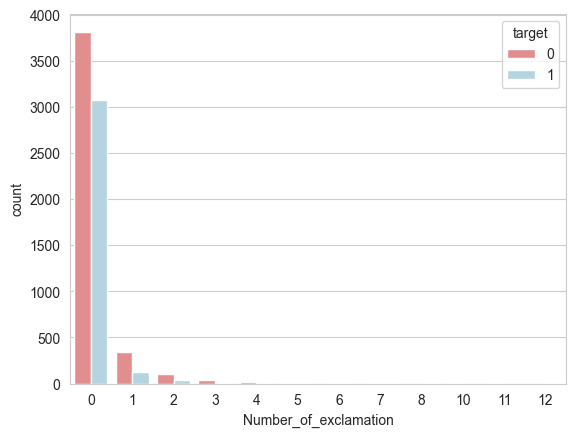

In [17]:
sns.countplot(df,x='Number_of_exclamation', hue='target',palette=['lightcoral', 'lightblue'])

In [18]:
pd.crosstab(df['Number_of_exclamation'], df['target'], normalize='index')*100

target,0,1
Number_of_exclamation,,
0,55.395997,44.604003
1,72.594142,27.405858
2,72.727273,27.272727
3,78.846154,21.153846
4,80.000000,20.000000
5,50.000000,50.000000
6,71.428571,28.571429
7,66.666667,33.333333
8,0.000000,100.000000


There is no obvious pattern, most tweets have 0,1,2 exclamation marks

In most groups there are more fake tweets

**Number of # vs target**

In [19]:
def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

In [20]:
df['Number_of_hashtags']= df['text'].apply(count_hashtags)
df.head(20)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation,Number_of_hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0,2
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,0,0,3
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,0,0,2
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,1,0,0
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,0,0,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,0,0,0


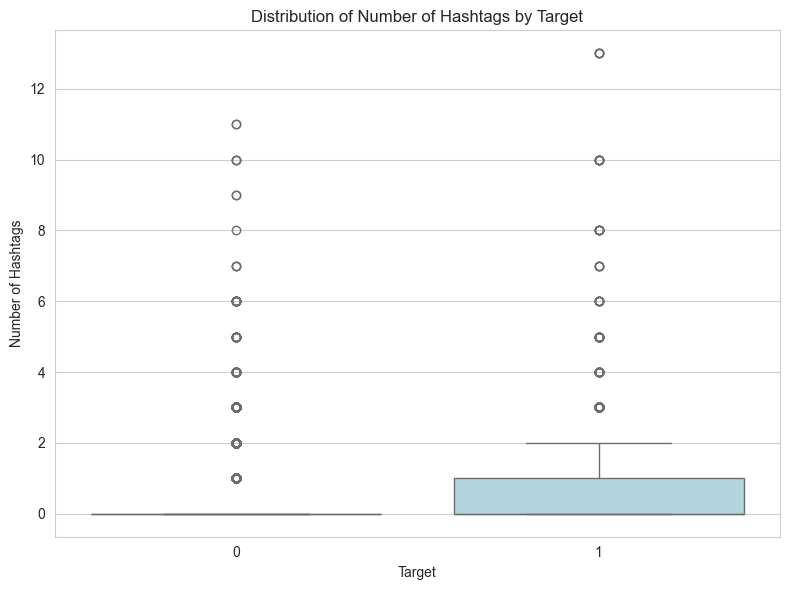

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='target', y='Number_of_hashtags', hue='target', palette=['lightcoral', 'lightblue'], dodge=False)
plt.legend().remove()
plt.xlabel('Target')
plt.ylabel('Number of Hashtags')
plt.title('Distribution of Number of Hashtags by Target')
plt.tight_layout()
plt.show()

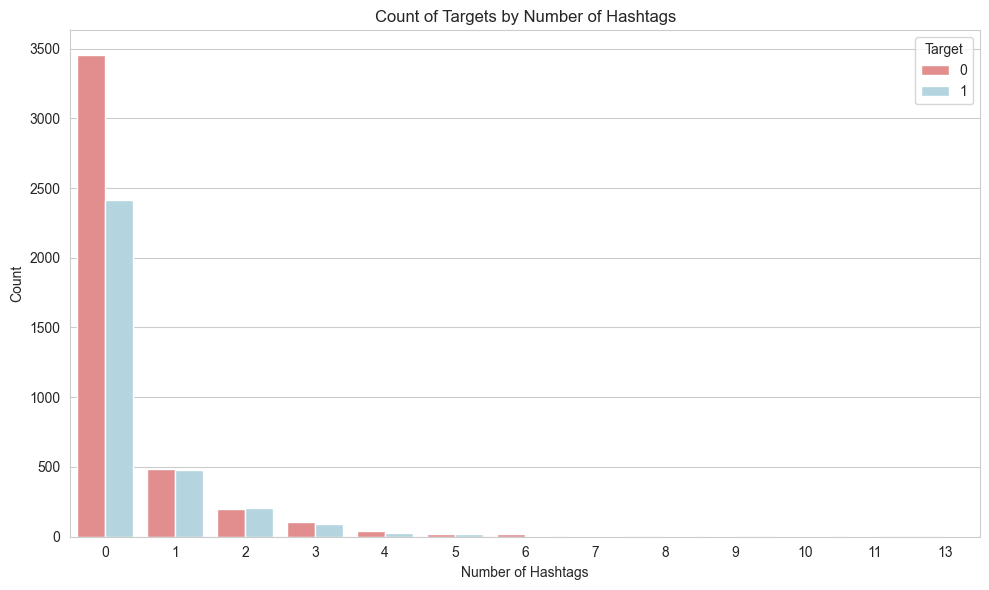

In [22]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Number_of_hashtags', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Number of Hashtags')
plt.xlabel('Number of Hashtags')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

The majority of tweets have 0 hashtags. For 1,2,3 hashtags there are circa 50/50 false and true tweets

**Number of words vs target**

In [23]:
def count_words(text):
    return len(text.split())

In [24]:
df['Word_count'] = df['text'].apply(count_words)

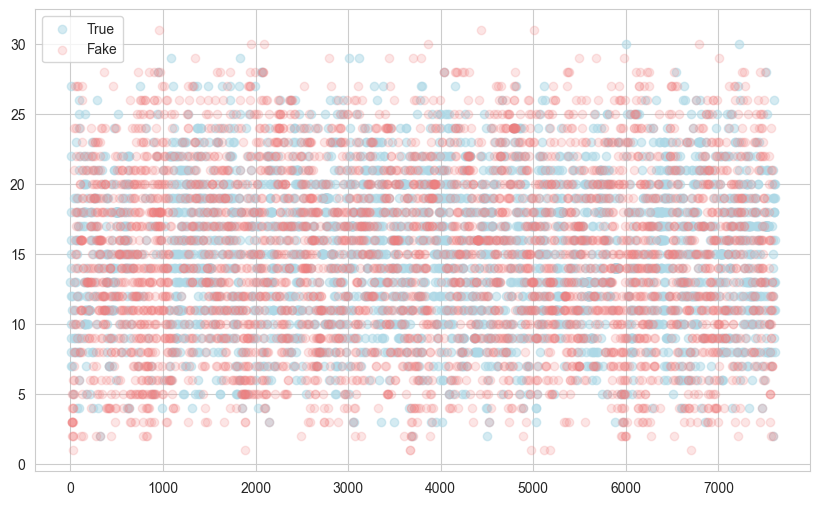

In [25]:
true = df[df['target']==1]
false = df[df['target']==0]

plt.figure(figsize=(10,6))
plt.scatter(true.index, true['Word_count'], label='True', color='lightblue',alpha=0.5)
plt.scatter(false.index, false['Word_count'], label='Fake', color='lightcoral',alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

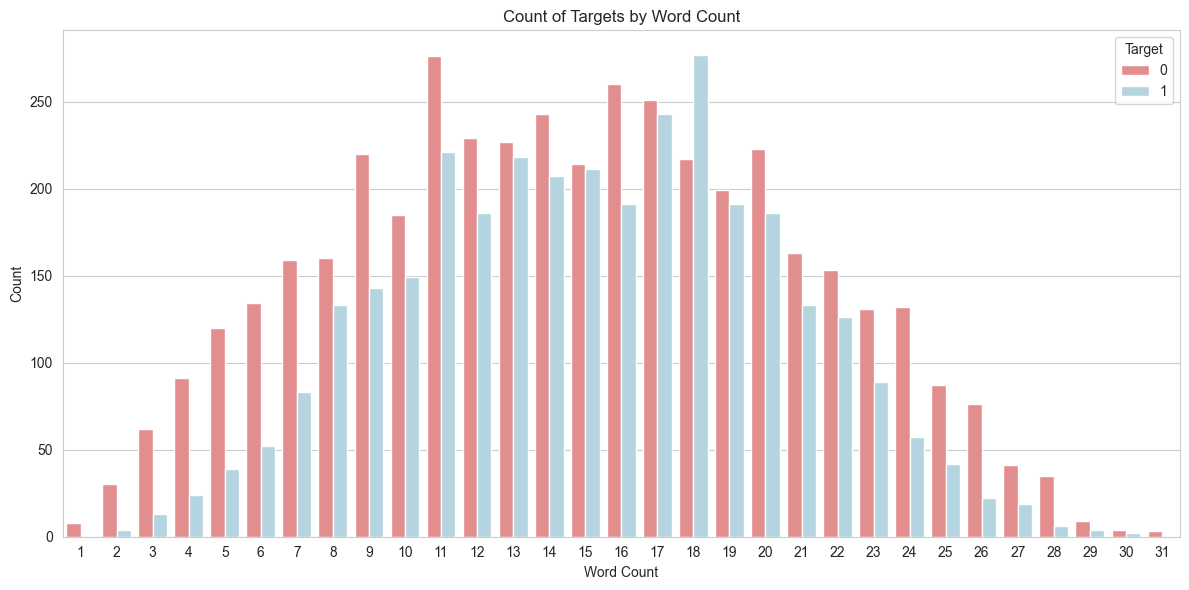

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Word_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Word Count')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

* there is no visible pattern between number of words and target
* We can only see that if the tweet is very short (1-10 words) or very long (>30 words) it is probably fake
* looks like normal distribution

**Punctuation vs target**

In [27]:
def count_punctuation(text):
    punctuation_pattern = r'[^\w\s]'
    punct = re.findall(punctuation_pattern, text)
    return len(punct)

In [28]:
df['Punctuation_count'] = df['text'].apply(count_punctuation)

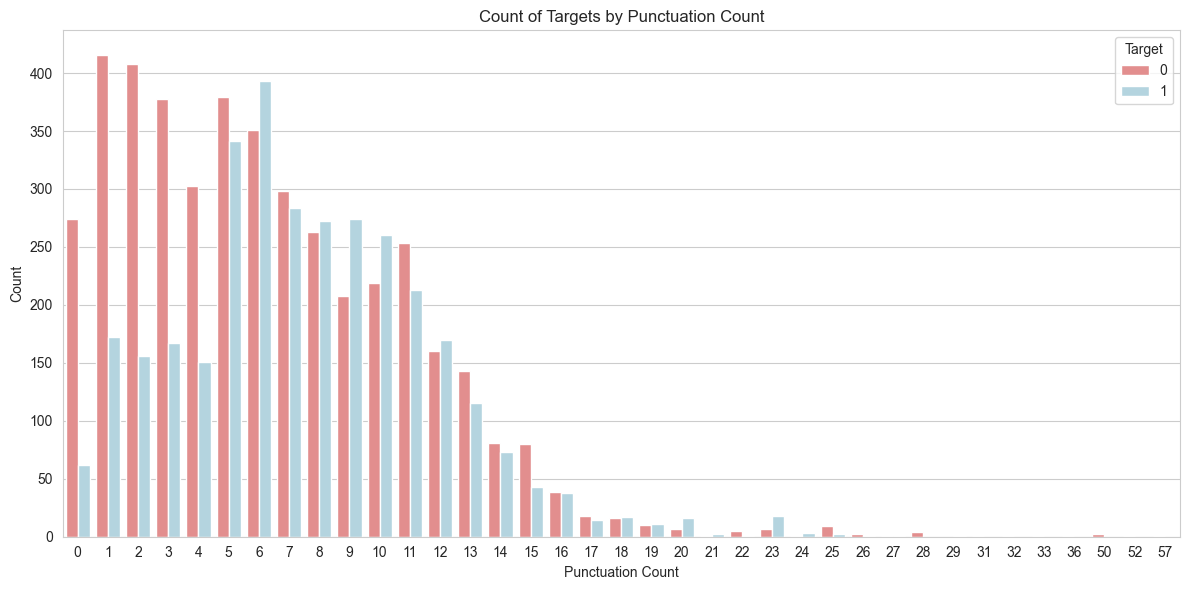

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Punctuation_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Punctuation Count')
plt.xlabel('Punctuation Count')
plt.ylabel('Count')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

* we can see a visible pattern : tweets with little punctuation tend to be fake, and tweets with 6-11 punctuation signs are more likely to be true

**Number of links vs target**

In [30]:
def count_links(text):
    url_pattern = r'https?://\S+|www\.\S+'
    links=re.findall(url_pattern,text)
    return len(links)

In [31]:
df['Link_count']=df['text'].apply(count_links)

<Axes: xlabel='Link_count', ylabel='count'>

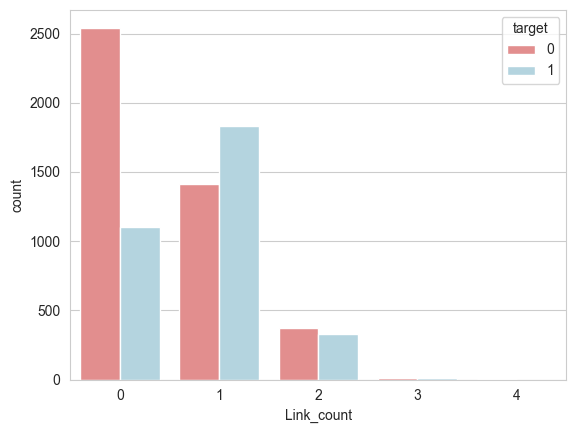

In [32]:
sns.countplot(df, x='Link_count', hue='target',palette=['lightcoral', 'lightblue'])

In [33]:
pd.crosstab(df['Link_count'], df['target'], normalize='index')*100

target,0,1
Link_count,,
0,69.824272,30.175728
1,43.517093,56.482907
2,52.932761,47.067239
3,59.090909,40.909091
4,100.000000,0.000000


**Number of stopwords vs target**

In [34]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))
    sw = [word for word in text.split() if word in stop_words]
    return len(sw)

In [35]:
df['Stopword_count']=df['text'].apply(count_stopwords)

<Axes: xlabel='Stopword_count', ylabel='count'>

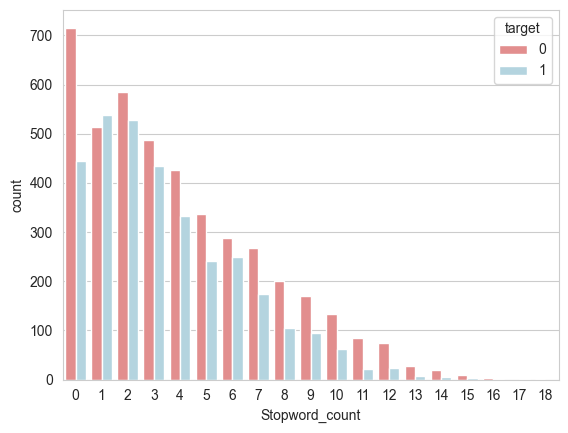

In [36]:
sns.countplot(df, x='Stopword_count', hue='target', palette=['lightcoral', 'lightblue'])

In [37]:
pd.crosstab(df['Stopword_count'],df['target'],normalize='index')*100

target,0,1
Stopword_count,,
0,61.724138,38.275862
1,48.812915,51.187085
2,52.565257,47.434743
3,52.819957,47.180043
4,56.126482,43.873518
5,58.304498,41.695502
6,53.445065,46.554935
7,60.407240,39.592760
8,65.901639,34.098361


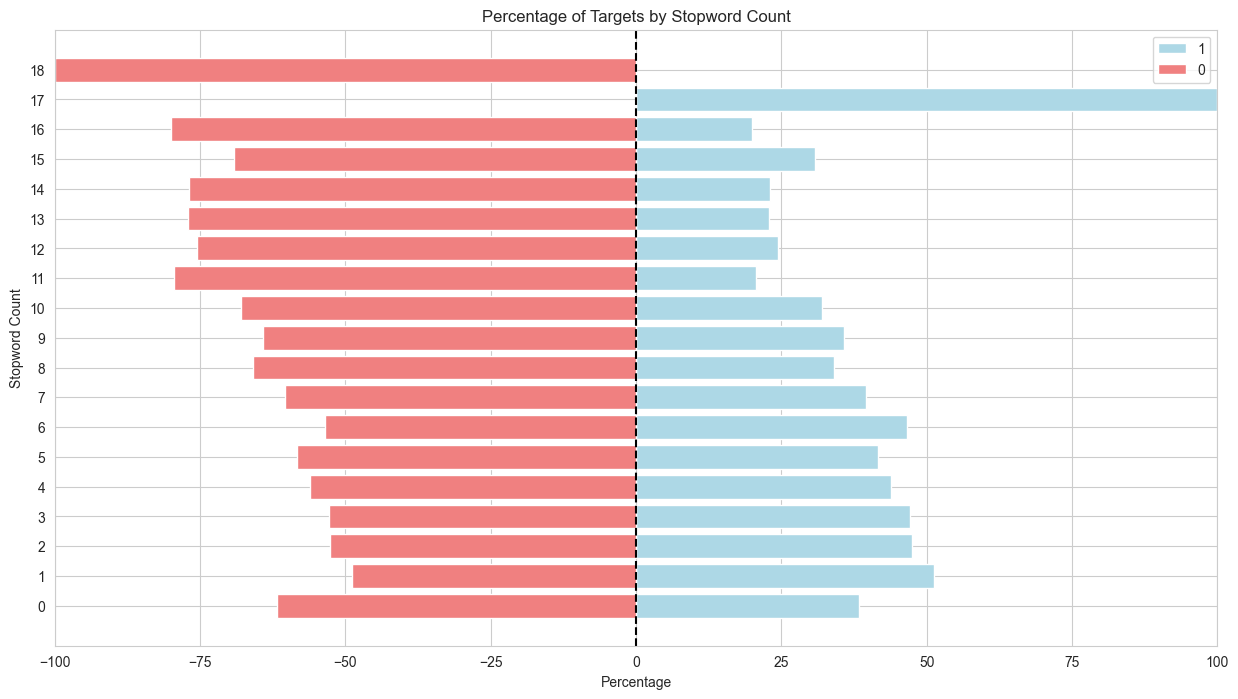

In [38]:
crosstab_normalized = pd.crosstab(df['Stopword_count'], df['target'], normalize='index') * 100

plt.figure(figsize=(15, 8))
legend_added = False
for index, row in crosstab_normalized.iterrows():
    plt.barh(
        str(index),
        row[1],
        color="lightblue",
        label="1" if not legend_added else "",
    )
    plt.barh(
        str(index),
        -row[0],
        color="lightcoral",
        label="0" if not legend_added else "",
    )
    if not legend_added:
        legend_added = True
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percentage")
plt.ylabel("Stopword Count")
plt.title("Percentage of Targets by Stopword Count")
plt.xlim(-100, 100)
plt.legend(loc="upper right")
plt.show()

* The percent of fake tweets is slightly higer when there are more stop words

**Number of mentions vs target**

In [39]:
def count_mentions(text):
    mention_pattern = r'@\w+'
    mentions=re.findall(mention_pattern,text)
    return len(mentions)
df['Mentions_count']=df['text'].apply(count_mentions)

<Axes: xlabel='Mentions_count', ylabel='count'>

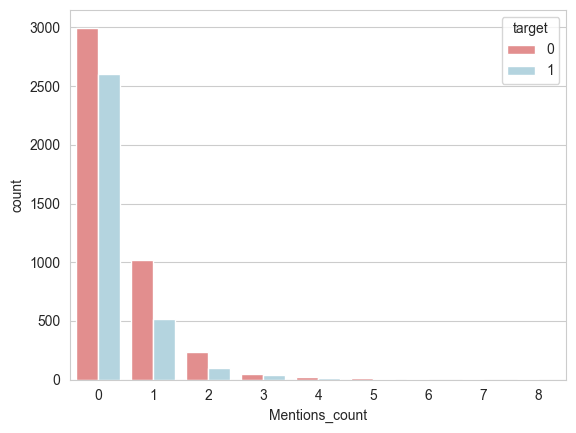

In [40]:
sns.countplot(df, x='Mentions_count', hue='target', palette=['lightcoral', 'lightblue'])

**Feature correlation**

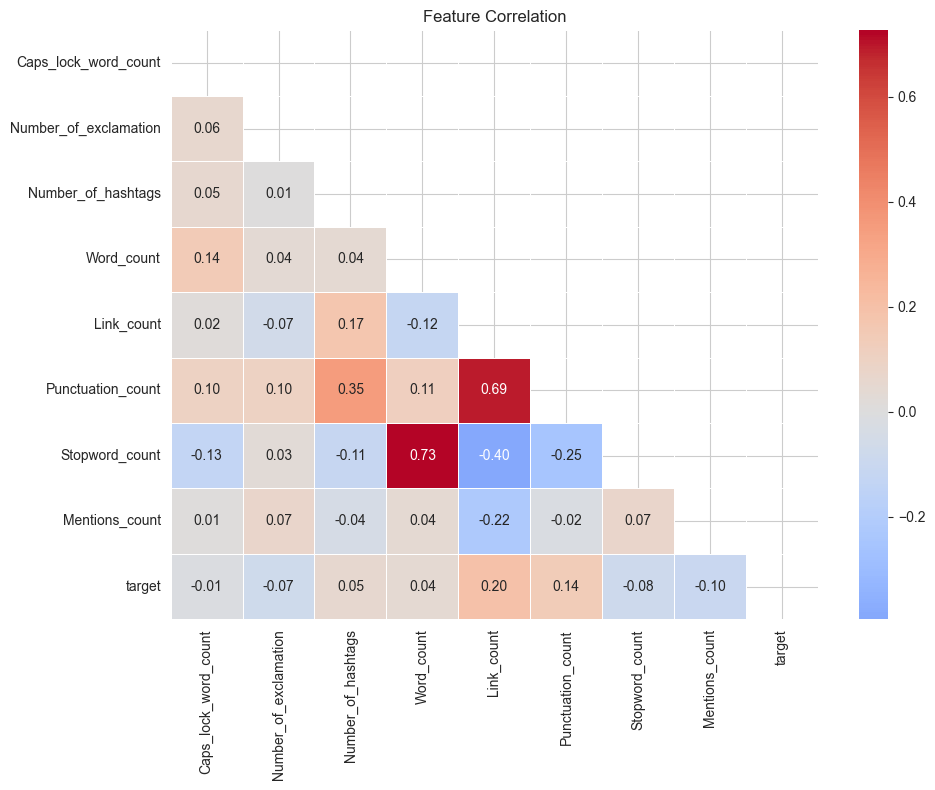

In [41]:
columns = ['Caps_lock_word_count', 'Number_of_exclamation', 'Number_of_hashtags', 
           'Word_count', 'Link_count', 'Punctuation_count', 'Stopword_count','Mentions_count', 'target']
correlation_matrix = df[columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, mask=mask, center=0)
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()

# Data preprocessing
* convert to lower case
* delete punctuation 
* remove https links
* remove stopwords (a, the, an ...)
* tokenise
* lemmatization

In [42]:
cleaned_text_df = df.copy()
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'\[.*?\]', '', text) # remove [] and things inside it 
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove links 
    text = re.sub(r'<.*?>+', '', text) # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = re.sub('\n', '', text) # remove newline
    text = re.sub(r'\w*\d\w*', '', text) # remove digits
    
    return text

In [43]:
lemmatizer = WordNetLemmatizer()

# tagging words
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'  # Adjective
    elif nltk_tag.startswith('V'):
        return 'v'  # Verb
    elif nltk_tag.startswith('N'):
        return 'n'  # Noun
    elif nltk_tag.startswith('R'):
        return 'r'  # Adverb
    else:          
        return None

# lemmatization with POS tagging 
def lemmatize_sentence(sentence):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

In [44]:
# processing text 
def processing_text(text): 
    text = clean_text(text)
    lematized = lemmatize_sentence(text)
    return lematized

# removing stop words
stop_words = set(stopwords.words('english'))
def filter_stop_words(tokenized_tweet):
    return [word for word in tokenized_tweet if word not in stop_words]

In [45]:
cleaned_text_df['cleaned_tokens'] = cleaned_text_df['text'].apply(processing_text).apply(filter_stop_words)
cleaned_text_df

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation,Number_of_hashtags,Word_count,Punctuation_count,Link_count,Stopword_count,Mentions_count,cleaned_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0,1,13,1,0,5,0,"[deed, reason, earthquake, may, allah, forgive, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,1,0,0,0,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0,0,22,3,0,9,0,"[resident, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0,1,8,2,0,1,0,"[people, receive, wildfire, evacuation, order, california]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0,2,16,2,0,6,0,"[get, send, photo, ruby, alaska, smoke, wildfire, pour, school]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,0,0,0,11,5,1,2,0,"[two, giant, crane, hold, bridge, collapse, nearby, home]"
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,0,0,0,20,4,0,7,2,"[control, wild, fire, california, even, northern, part, state, trouble]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,2,0,0,8,11,1,1,0,"[volcano, hawaii]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,0,0,0,19,5,0,5,0,"[police, investigate, ebike, collide, car, little, portugal, ebike, rider, suffer, serious, nonlife, threatening, injury]"
